In [1]:
# wykorzystane biblioteki
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score

from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

In [4]:
#df_org = pd.read_excel('cars_clean.xlsx', index_col=0)
# wczytywanie danych (wymagana biblioteka fastparquet)
df_org = pd.read_parquet('data/cars_clean.parquet')
df_org.drop(columns=['zabytek', 'stan', 'tuning', 'kierownica_po_prawej'], inplace=True)
df_org.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75169 entries, 0 to 75168
Columns: 24 entries, cena to zarejestrowany_w_pl
dtypes: float64(1), int64(8), object(15)
memory usage: 14.3+ MB


features calculation

In [5]:
df = df_org.copy()

# kodowanie zmiennych
for col in df.select_dtypes('object').columns:
    df[col] = df[col].replace([np.NaN, 'tak'], [0,1]).astype('object')

# dodatkowe zmienne
df['marka_mediana'] = df.groupby('marka')['cena'].transform('median')
df['marka_var'] = df.groupby('marka')['cena'].transform('var').fillna(0)
df['marka_min'] = df.groupby('marka')['cena'].transform('min')
df['marka_max'] = df.groupby('marka')['cena'].transform('max')
# df.head(3)

In [6]:
# MODEL FEATURES
df['model_mean'] = df.groupby('model')['cena'].transform('mean')
df['model_count'] = df.groupby('model')['model'].transform('count')
df['model_var'] =  df.groupby('model')['cena'].transform('var').fillna(0)
df['model_q25'] = df.groupby('model')['cena'].transform(lambda x: x.quantile(0.25))
df['model_q75'] = df.groupby('model')['cena'].transform(lambda x: x.quantile(0.75))
df['skrzynia_mediana'] = df.groupby('skrzynia')['cena'].transform('median')
df['skrzynia_var'] = df.groupby('skrzynia')['cena'].transform('var')
df['uszkodzony_mediana'] = df.groupby('uszkodzony')['cena'].transform('median')
df['uszkodzony_var'] = df.groupby('uszkodzony')['cena'].transform('var')
df['pierwszy_wlasciciel_mediana'] = df.groupby('pierwszy_wlasciciel')['cena'].transform('median')
df['pierwszy_wlasciciel_var'] = df.groupby('pierwszy_wlasciciel')['cena'].transform('var')
df['waluta_mediana'] = df.groupby('waluta')['cena'].transform('median')
df['moc_corr'] = df['moc_km'].corr(df['cena'])
df['pojemnosc_corr'] = df['pojemnosc_cm3'].corr(df['cena'])
df['przebieg_corr'] = df['przebieg_km'].corr(df['cena'])
df['spalanie_corr'] = df['spalanie'].corr(df['cena'])
df['wiek_corr'] = df['wiek'].corr(df['cena'])
df['moc_bin'] = pd.qcut(df['moc_km'], q=10, labels=list(range(10))).astype('int8')
df['przebieg_bin'] = pd.qcut(df['przebieg_km'], q=4, labels=list(range(4))).astype('int8')
df['pojemnosc_bin'] = pd.qcut(df['pojemnosc_cm3'], q=4, labels=list(range(4))).astype('int8')
df['wiek'] = pd.qcut(df['wiek'], q=5, labels=list(range(5))).astype('int8')




Onehotencoding

In [7]:
# kodowanie zmiennych na 0-1
onehot = OneHotEncoder(sparse=False)
to_encode = df.select_dtypes(include = ['object', 'int8']).copy()
onehot_encoded = onehot.fit_transform(to_encode)
df_encoded = pd.DataFrame(onehot_encoded, columns=onehot.get_feature_names_out()).astype('int8')
df = pd.concat([df, df_encoded], axis=1)
df = df.drop(to_encode.columns, axis=1)
df.reset_index(drop=True)

df.to_parquet('cars_clean_features.parquet')
df.info()

/Users/Kuba/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


<class 'pandas.core.frame.DataFrame'>
Int64Index: 75169 entries, 0 to 75168
Columns: 796 entries, cena to pojemnosc_bin_3
dtypes: float64(19), int64(10), int8(767)
memory usage: 72.2 MB


In [8]:
df = pd.read_parquet('data/cars_clean_features.parquet')
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75169 entries, 0 to 75168
Columns: 796 entries, cena to pojemnosc_bin_3
dtypes: float64(19), int64(10), int8(767)
memory usage: 72.2 MB


In [9]:
# podział danych na zbiór treningowy i testowy
x = df.iloc[:,1:]
y = df.iloc[:,0] 

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25,stratify=x['marka_var'], random_state=34)

In [10]:
# regresja liniowa
model = LinearRegression()
# train - test
model.fit(x_train, y_train)
pred = model.predict(x_test)
pred_train = model.predict(x_train)
errors = y_test - pred
relative_errors = abs((y_test-pred)/pred)*100
df_errors_lm = pd.DataFrame({'actual': y_test, 'predicted': pred, 'error': errors, 'relative_error': relative_errors})

# walidacja krzyżowa
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=34)
rmse_cv = []
  
for train_index, test_index in skf.split(x, y, df_org['model']):
    x_train_fold, x_test_fold = x.loc[train_index,:], x.loc[test_index,:]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    model.fit(x_train_fold, y_train_fold)
    pred_fold = model.predict(x_test_fold)
    rmse_cv.append(mean_squared_error(y_test_fold, pred_fold)**0.5)

print(rmse_cv)
pd.DataFrame({
    'Model': ['Linear Model'],
    'Train RMSE': [np.round(mean_squared_error(y_train, pred_train)**0.5,0)],
    'Train R2': [np.round(r2_score(y_train, pred_train),2)],
    'Test RMSE': [np.round(mean_squared_error(y_test, pred)**0.5,0)],
    'Test R2': [np.round(r2_score(y_test, pred),2)],
    'CV RMSE': [np.round(np.mean(rmse_cv),0)]
            })

/Users/Kuba/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[22241.325841445483, 22446.831956886865, 22127.368729400212, 22061.02014363373, 22553.3648750492]


,Model,Train RMSE,Train R2,Test RMSE,Test R2,CV RMSE
0,Linear Model,21931.0,0.85,22286.0,0.84,22286.0


In [11]:
# Regresja Grzbietowa
model = Ridge(alpha=0.3, solver='svd')
# train - test
model.fit(x_train, y_train)
pred = model.predict(x_test)
pred_train = model.predict(x_train)
errors = y_test - pred
relative_errors = abs((y_test-pred)/pred)*100
df_errors_ridge = pd.DataFrame({'actual': y_test, 'predicted': pred, 'error': errors, 'relative_error': relative_errors})
# walidacja krzyżowa
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=34)
rmse_cv = []
  
for train_index, test_index in skf.split(x, y, df_org['model']):
    x_train_fold, x_test_fold = x.loc[train_index,:], x.loc[test_index,:]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    model.fit(x_train_fold, y_train_fold)
    pred_fold = model.predict(x_test_fold)
    rmse_cv.append(mean_squared_error(y_test_fold, pred_fold)**0.5)

print(rmse_cv)
pd.DataFrame({
    'Model': ['Ridge'],
    'Train RMSE': [np.round(mean_squared_error(y_train, pred_train)**0.5,0)],
    'Train R2': [np.round(r2_score(y_train, pred_train),2)],
    'Test RMSE': [np.round(mean_squared_error(y_test, pred)**0.5,0)],
    'Test R2': [np.round(r2_score(y_test, pred),2)],
    'CV RMSE': [np.round(np.mean(rmse_cv),0)]
            })


/Users/Kuba/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[22237.59244072124, 22441.09995380738, 22115.358952189406, 22043.994355711882, 22543.453397901867]


,Model,Train RMSE,Train R2,Test RMSE,Test R2,CV RMSE
0,Ridge,21935.0,0.85,22280.0,0.84,22276.0


In [ ]:
# szukanie najlepszych hiperparametrów dla drzewa decyzyjnego
parameters = {
    'max_depth': sp_randint(12,30),
    'max_features': [0.5,0.6,0.7,0.8,0.9,1],
    'min_samples_split': sp_randint(5, 60),
    'min_samples_leaf': sp_randint(3, 30),
    'ccp_alpha': [0.00001,0.05, 0.1, 0.3],
    'random_state': [34]
}

grid_obj = RandomizedSearchCV(estimator=DecisionTreeRegressor(),
                            param_distributions=parameters,
                            cv=5,
                            n_iter=400,
                            refit=True,
                            scoring = 'neg_mean_squared_error',
                            random_state=34,
                            n_jobs = 4,
                            verbose=1)

grid_obj.fit(x, y)
grid_obj.best_estimator_

In [12]:
# Drzewo decyzyjne
model = DecisionTreeRegressor(max_depth=23, min_samples_leaf=15, min_samples_split=28, max_features=0.8)

model.fit(x_train, y_train)
pred = model.predict(x_test)
pred_train = model.predict(x_train)
errors = y_test - pred
relative_errors = abs((y_test-pred)/pred)*100
df_errors_tree = pd.DataFrame({'actual': y_test, 'predicted': pred, 'error': errors, 'relative_error': relative_errors})
# walidacja krzyżowa 
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=34)
rmse_cv = []
  
for train_index, test_index in skf.split(x, y, df_org['model']):
    x_train_fold, x_test_fold = x.loc[train_index,:], x.loc[test_index,:]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    model.fit(x_train_fold, y_train_fold)
    pred_fold = model.predict(x_test_fold)
    rmse_cv.append(mean_squared_error(y_test_fold, pred_fold)**0.5)

print(rmse_cv)
pd.DataFrame({
    'Model': ['Ridge'],
    'Train RMSE': [np.round(mean_squared_error(y_train, pred_train)**0.5,0)],
    'Train R2': [np.round(r2_score(y_train, pred_train),2)],
    'Test RMSE': [np.round(mean_squared_error(y_test, pred)**0.5,0)],
    'Test R2': [np.round(r2_score(y_test, pred),2)],
    'CV RMSE': [np.round(np.mean(rmse_cv),0)]
            })
# CV 16295

/Users/Kuba/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[16558.177878107126, 16461.7126440515, 16050.98104887508, 16116.669155491327, 16474.805778513055]


,Model,Train RMSE,Train R2,Test RMSE,Test R2,CV RMSE
0,Ridge,13631.0,0.94,16625.0,0.91,16332.0


In [5]:
# szukanie najlepszych hiperparametrów dla lasów losowych
parameters = {
    'max_depth': sp_randint(12,23),
    'n_estimators': sp_randint(100,350),
    'max_features': [0.6,0.7,0.8,0.9,1],
    'min_samples_split': sp_randint(5, 60),
    'min_samples_leaf': sp_randint(3, 30),
    'ccp_alpha': [0,0.05, 0.1],
    'random_state': [34]
}

grid_obj = RandomizedSearchCV(estimator=RandomForestRegressor(),
                            param_distributions=parameters,
                            cv=5,
                            n_iter=200,
                            refit=True,
                            scoring = 'neg_mean_squared_error',
                            random_state=34,
                            n_jobs = 5,
                            verbose=3)

grid_obj.fit(x, y)
grid_obj.best_estimator_

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomForestRegressor(ccp_alpha=0.1, max_depth=21, max_features=0.6,
                      min_samples_leaf=6, min_samples_split=10,
                      n_estimators=325, random_state=34)

In [13]:
# RandomForestRegressor(ccp_alpha=0.1, max_depth=21, max_features=0.6,
#                       min_samples_leaf=6, min_samples_split=10,
#                       n_estimators=325, random_state=34)

In [14]:
# Lasy losowe
model = RandomForestRegressor(max_depth=18, min_samples_split=4, n_estimators=170, n_jobs=6, random_state=34)
# train - test
model.fit(x_train, y_train)
pred = model.predict(x_test)
pred_train = model.predict(x_train)
errors = y_test - pred
relative_errors = abs((y_test-pred)/pred)*100
df_errors_rf = pd.DataFrame({'actual': y_test, 'predicted': pred, 'error': errors, 'relative_error': relative_errors})
# walidacja krzyżowa
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=34)
rmse_cv = []
  
for train_index, test_index in skf.split(x, y, df_org['model']):
    x_train_fold, x_test_fold = x.loc[train_index,:], x.loc[test_index,:]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    model.fit(x_train_fold, y_train_fold)
    pred_fold = model.predict(x_test_fold)
    rmse_cv.append(mean_squared_error(y_test_fold, pred_fold)**0.5)

print(rmse_cv)
pd.DataFrame({
    'Model': ['Ridge'],
    'Train RMSE': [np.round(mean_squared_error(y_train, pred_train)**0.5,0)],
    'Train R2': [np.round(r2_score(y_train, pred_train),2)],
    'Test RMSE': [np.round(mean_squared_error(y_test, pred)**0.5,0)],
    'Test R2': [np.round(r2_score(y_test, pred),2)],
    'CV RMSE': [np.round(np.mean(rmse_cv),0)]
            })

/Users/Kuba/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[12620.879044583424, 12976.72089104217, 12495.773890742918, 12554.839131366287, 13003.712431575135]


,Model,Train RMSE,Train R2,Test RMSE,Test R2,CV RMSE
0,Ridge,6128.0,0.99,12861.0,0.95,12730.0


Errors analysis

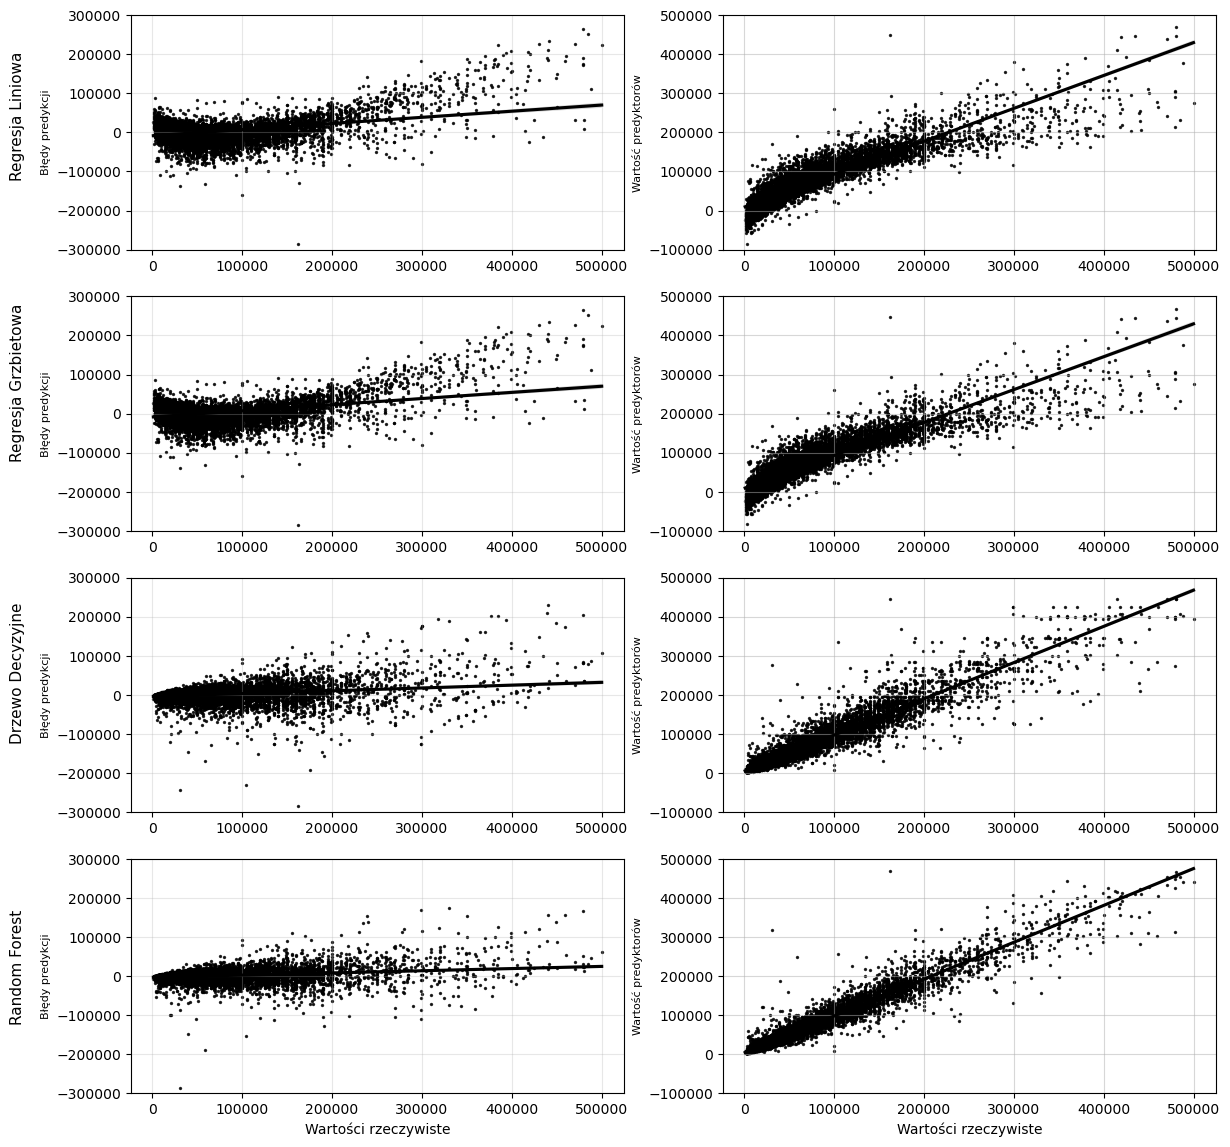

In [17]:
fig, axs = plt.subplots(4,2, figsize=(14,14))

dfs = [df_errors_lm, df_errors_ridge, df_errors_tree, df_errors_rf]
titles = ['Regresja Liniowa', 'Regresja Grzbietowa', 'Drzewo Decyzyjne', 'Random Forest']

for row, df in enumerate(dfs):
    sns.regplot(data=df, x='actual', y='error', fit_reg=True, color='black', scatter_kws={'s':2}, ax=axs[row, 0])
    axs[row,0].grid(alpha=0.3)
    axs[row,0].set_title(titles[row], fontsize=11, rotation='vertical', x=-0.23,y=0.27)
    axs[row,0].set_xlabel('')
    axs[row,0].set_ylabel('Błędy predykcji', fontsize=8)
    axs[row,0].set_ylim([-3E5, 3E5])
axs[3,0].set_xlabel('Wartości rzeczywiste')

for row, df in enumerate(dfs):
    sns.regplot(data=df, x='actual', y='predicted', fit_reg=True, color='black', scatter_kws={'s':2}, ax=axs[row, 1])
    axs[row,1].grid(alpha=0.5)
    #axs[row,1].set_title(titles[row], fontsize=8)
    axs[row,1].set_xlabel('')
    axs[row,1].set_ylabel('Wartość predyktorów', fontsize=8)
    axs[row,1].set_ylim([-1E5, 5E5])
axs[3,1].set_xlabel('Wartości rzeczywiste')
plt.show()